In [1]:
from matplotlib.patches import Ellipse
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as optimize

from artificialdata import init, time_vec, odes, obs, p_vec

%matplotlib inline
np.random.seed(42)

In [2]:
Vmax_actual, Km_actual = p_vec

In [3]:
def error(p, t, init):
    return (odeint(odes, init, t, args=(p,)) - obs).flatten()

In [4]:
my_bounds = ([0, 0], [100, 10])
guess = []
for i, j in zip(*my_bounds):
    guess.append(np.random.uniform(i, j))
print(guess)

[37.454011884736246, 9.50714306409916]


In [5]:
sol_ls = optimize.least_squares(error, guess, args=(time_vec, init, ), bounds=my_bounds)

# Getting the covariance matrix

In [6]:
# https://stackoverflow.com/questions/40187517/getting-covariance-matrix-of-fitted-parameters-from-scipy-optimize-least-squares
cost = 2 * sol_ls.cost # sol_ls.cost is half sum of squares!
H = np.dot(sol_ls.jac.T, sol_ls.jac)
cov0 = np.linalg.inv(H)
df = len(obs.flatten()) - len(sol_ls.x)  # degrees of freedom
cov = cov0*cost/df
print(cov.round(1))

[[ 19167.6  11079. ]
 [ 11079.    6408.2]]


In [7]:
standard_errors = np.sqrt(np.diag(cov))
ci_deltas = stats.t.isf(0.025, df=df) * standard_errors
sol_df = pd.DataFrame({'estimate': sol_ls.x})
sol_df['lower_bound'] = sol_df['estimate'] - ci_deltas.T
sol_df['upper_bound'] = sol_df['estimate'] + ci_deltas.T
sol_df[['lower_bound', 'estimate', 'upper_bound']]

,lower_bound,estimate,upper_bound
0,-293.188909,26.070776,345.330462
1,-174.597992,10.000000,194.597992


In [8]:
def ellipse_from_cov(cov, center):
    eigvals, eigvecs = np.linalg.eigh(cov)

    # The counter-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    scale = np.sqrt(stats.chi2.ppf(0.95, 2))

    # Width and height of ellipse to draw
    width, height = 2 * scale * np.sqrt(eigvals)
    e = Ellipse(xy=center, width=width, height=height,
               angle=np.degrees(theta))
    return e

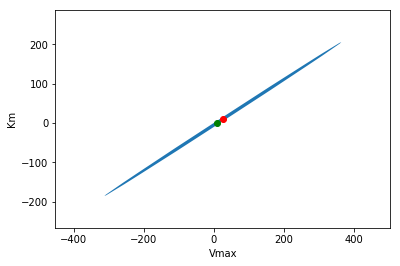

In [9]:
center_ls = sol_ls.x

e = ellipse_from_cov(cov, center_ls)

fig, ax = plt.subplots()
ax.set_xlim(center_ls[0] - ci_deltas[0]*1.5, center_ls[0] + ci_deltas[0]*1.5)
ax.set_ylim(center_ls[1] - ci_deltas[1]*1.5, center_ls[1] + ci_deltas[1]*1.5)
ax.add_artist(e)
ax.plot(center_ls[0], center_ls[1], 'ro')
ax.plot(Vmax_actual, Km_actual, 'go')
ax.set_xlabel('Vmax')
ax.set_ylabel('Km');

# Importing results from pymc simulation

In [10]:
mcmc = pd.read_pickle('v_input_09.pkl')

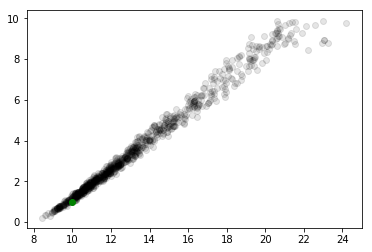

In [11]:
plt.scatter(mcmc['Vmax'], mcmc['Km'], color='k', alpha=0.1)
plt.plot(Vmax_actual, Km_actual, 'go');

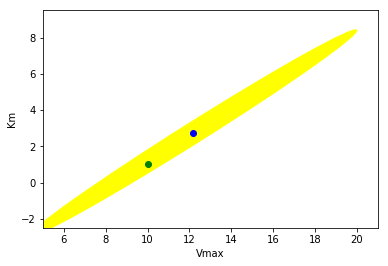

In [12]:
center_mcmc = mcmc[['Vmax', 'Km']].median().values
e2 = ellipse_from_cov(mcmc[['Vmax', 'Km']].cov().values, center_mcmc)
e2.set_color('yellow')
fig, ax = plt.subplots()
ax.set_xlim(5, 21)
ax.set_ylim(-2.5, 9.5)

ax.add_artist(e2)
ax.plot(center_mcmc[0], center_mcmc[1], 'bo')
ax.plot(Vmax_actual, Km_actual, 'go')
ax.set_xlabel('Vmax')
ax.set_ylabel('Km');

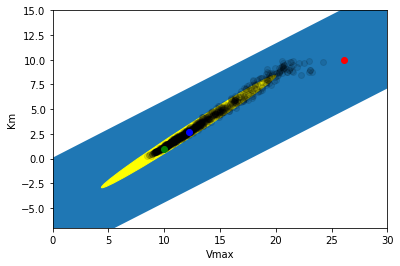

In [13]:
e_large = ellipse_from_cov(cov, center_ls)
e_large.set_zorder(0)
e_small = ellipse_from_cov(mcmc[['Vmax', 'Km']].cov().values, center_mcmc)
e_small.set_color('yellow')
e_small.set_zorder(1)

fig, ax = plt.subplots()
ax.set_xlim(0, 30)
ax.set_ylim(-7, 15)
ax.add_artist(e_large)
ax.add_artist(e_small)
ax.scatter(mcmc['Vmax'], mcmc['Km'], color='k', alpha=0.1, zorder=3)
ax.plot(center_ls[0], center_ls[1], 'ro', zorder=4)
ax.plot(center_mcmc[0], center_mcmc[1], 'bo', zorder=5)
ax.plot(Vmax_actual, Km_actual, 'go', zorder=6)
ax.set_xlabel('Vmax')
ax.set_ylabel('Km');

# Predicting a new condition

In [14]:
def odes_new(x, t, p):
    """
    Input rate changed from 9 to 20
    """
    Vmax = p[0]
    Km = p[1]
    return np.array([
        # 9 - Vmax * x[0] / (Km + x[0]),
        20 - Vmax * x[0] / (Km + x[0]),
        ])

xt_actual = odeint(odes_new, init, time_vec, args=(p_vec,))
xt_ls = odeint(odes_new, init, time_vec, args=(center_ls,))
xt_mcmc = odeint(odes_new, init, time_vec, args=(center_mcmc,))

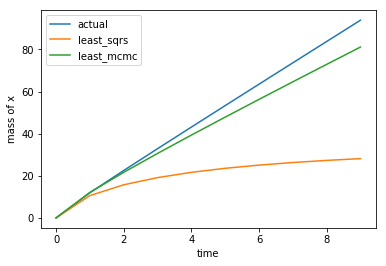

In [15]:
plt.plot(time_vec, xt_actual, label='actual')
plt.plot(time_vec, xt_ls, label='least_sqrs')
plt.plot(time_vec, xt_mcmc, label='least_mcmc')
plt.legend()
plt.xlabel('time')
plt.ylabel('mass of x');

In [16]:
# Euclidean distances
ss_ls = ((xt_actual - xt_ls)**2).sum()
ss_mcmc = ((xt_actual - xt_mcmc)**2).sum()
print('Distance ls {0:2f}'.format(ss_ls))
print('Distance mcmc {0:2f}'.format(ss_mcmc))

Distance ls 12802.852223
Distance mcmc 463.679245
